In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")




In [63]:
def months_ahead(from_date, to_date):
    """
    Utility: calculate how many months from 'from_date' to 'to_date'.
    Assumes both are month-start if your data is monthly.
    """
    return (to_date.year - from_date.year)*12 + (to_date.month - from_date.month)



In [64]:
df = pd.read_csv("air-traffic-landings-statistics.csv", encoding='latin1')
df.head()


,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,201809,SkyWest Airlines,OO,United Airlines,UA,International,Canada,Passenger,Regional Jet,Bombardier,CRJ2,-,30,1410000
1,201809,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Narrow Body,Airbus,A320,-,125,17787978
2,201809,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Passenger,Wide Body,Boeing,B773,-,30,16620000
3,201809,"COPA Airlines, Inc.",CM,"COPA Airlines, Inc.",CM,International,Central America,Passenger,Narrow Body,Boeing,B739,-,3,491700
4,201809,Hong Kong Airlines Limited,HX,Hong Kong Airlines Limited,HX,International,Asia,Passenger,Wide Body,Airbus,A359,-,16,7301712


In [65]:
df = df.apply(lambda x: x.str.lower() if x.dtype == object else x)

df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,201809,skywest airlines,oo,united airlines,ua,international,canada,passenger,regional jet,bombardier,crj2,-,30,1410000
1,201809,air canada,ac,air canada,ac,international,canada,passenger,narrow body,airbus,a320,-,125,17787978
2,201809,japan airlines,jl,japan airlines,jl,international,asia,passenger,wide body,boeing,b773,-,30,16620000
3,201809,"copa airlines, inc.",cm,"copa airlines, inc.",cm,international,central america,passenger,narrow body,boeing,b739,-,3,491700
4,201809,hong kong airlines limited,hx,hong kong airlines limited,hx,international,asia,passenger,wide body,airbus,a359,-,16,7301712


In [66]:
df.drop_duplicates(inplace = True)
df.shape

(22045, 14)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22045 entries, 0 to 22046
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              22045 non-null  int64 
 1   Operating Airline            22045 non-null  object
 2   Operating Airline IATA Code  21970 non-null  object
 3   Published Airline            22045 non-null  object
 4   Published Airline IATA Code  21970 non-null  object
 5   GEO Summary                  22045 non-null  object
 6   GEO Region                   22045 non-null  object
 7   Landing Aircraft Type        22045 non-null  object
 8   Aircraft Body Type           22045 non-null  object
 9   Aircraft Manufacturer        22034 non-null  object
 10  Aircraft Model               22045 non-null  object
 11  Aircraft Version             20887 non-null  object
 12  Landing Count                22045 non-null  int64 
 13  Total Landed Weight          22045 n

In [68]:
df.isna().sum()

Activity Period                   0
Operating Airline                 0
Operating Airline IATA Code      75
Published Airline                 0
Published Airline IATA Code      75
GEO Summary                       0
GEO Region                        0
Landing Aircraft Type             0
Aircraft Body Type                0
Aircraft Manufacturer            11
Aircraft Model                    0
Aircraft Version               1158
Landing Count                     0
Total Landed Weight               0
dtype: int64

In [69]:
df.isnull().sum() / len(df)

Activity Period                0.000000
Operating Airline              0.000000
Operating Airline IATA Code    0.003402
Published Airline              0.000000
Published Airline IATA Code    0.003402
GEO Summary                    0.000000
GEO Region                     0.000000
Landing Aircraft Type          0.000000
Aircraft Body Type             0.000000
Aircraft Manufacturer          0.000499
Aircraft Model                 0.000000
Aircraft Version               0.052529
Landing Count                  0.000000
Total Landed Weight            0.000000
dtype: float64

In [70]:
df.isna().sum()//len(df)*100

Activity Period                0
Operating Airline              0
Operating Airline IATA Code    0
Published Airline              0
Published Airline IATA Code    0
GEO Summary                    0
GEO Region                     0
Landing Aircraft Type          0
Aircraft Body Type             0
Aircraft Manufacturer          0
Aircraft Model                 0
Aircraft Version               0
Landing Count                  0
Total Landed Weight            0
dtype: int64

In [71]:
mean_cleaned = df['Landing Count'].dropna().mean()
print("Mean after dropping missing values:", mean_cleaned)
# Calculate the median of Total Landed Weight
median_total_weight = df['Total Landed Weight'].median()
print("Median Total Landed Weight:", median_total_weight)
# Drop missing values and calculate median
median_cleaned = df['Landing Count'].dropna().median()
print("Median after handling missing values:", median_cleaned)

Mean after dropping missing values: 113.39242458607394
Median Total Landed Weight: 9660000.0
Median after handling missing values: 31.0


In [72]:
# Convert Activity Period (e.g. 201809 -> "2018-09-01")
df['Activity Period'] = df['Activity Period'].astype(str)
df['year'] = df['Activity Period'].str[:4].astype(int)
df['month'] = df['Activity Period'].str[4:].astype(int)
df['date'] = pd.to_datetime(df[['year','month']].assign(day=1))  # always day=1
df.sort_values('date', inplace=True)


In [73]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight,year,month,date
22046,200507,skywest airlines,oo,united airlines - pre 07/01/2013,ua,domestic,us,passenger,turbo prop,embraer,erj,120,1655,42699000,2005,7,2005-07-01
21945,200507,us airways,us,us airways,us,domestic,us,passenger,narrow body,airbus,a319,NaN,148,20379700,2005,7,2005-07-01
21946,200507,virgin atlantic,vs,virgin atlantic,vs,international,europe,passenger,wide body,boeing,747,400,31,19530000,2005,7,2005-07-01
21947,200507,air canada,ac,air canada,ac,international,canada,passenger,narrow body,airbus,a321,211,2,343040,2005,7,2005-07-01
21948,200507,united airlines - pre 07/01/2013,ua,united airlines - pre 07/01/2013,ua,domestic,us,passenger,wide body,boeing,747,422,39,24570000,2005,7,2005-07-01


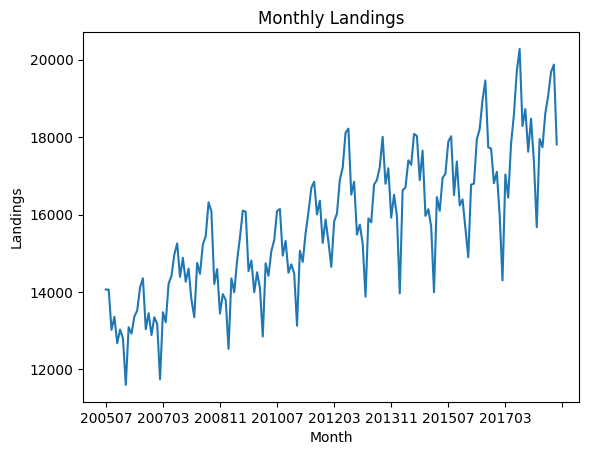

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
# Summary of landings by month
monthly_landings = df.groupby('Activity Period')['Landing Count'].sum()
monthly_landings.plot(kind='line', title='Monthly Landings', xlabel='Month', ylabel='Landings')
plt.show()

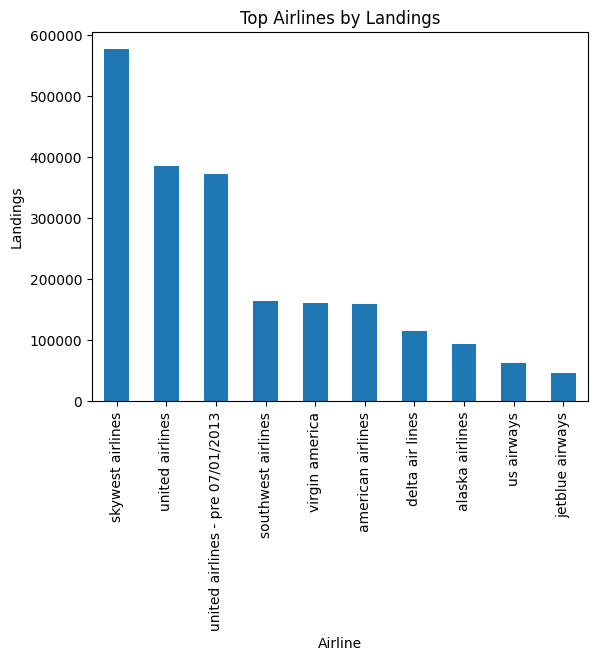

In [75]:
# Top operating airlines by landing count
top_airlines = df.groupby('Operating Airline')['Landing Count'].sum().sort_values(ascending=False).head(10)
top_airlines.plot(kind='bar', title='Top Airlines by Landings', xlabel='Airline', ylabel='Landings')
plt.xticks(rotation = 90)
plt.show()

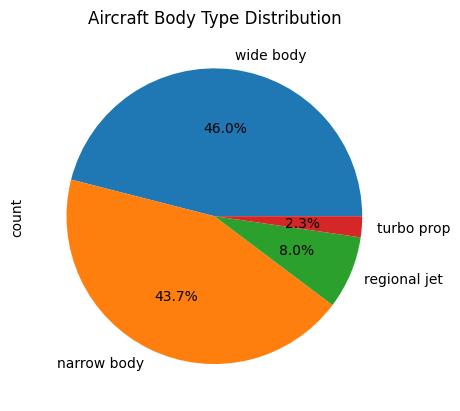

In [76]:
# Aircraft body type distribution
body_type_distribution = df['Aircraft Body Type'].value_counts()
body_type_distribution.plot(kind='pie', autopct='%1.1f%%', title='Aircraft Body Type Distribution')
plt.show()

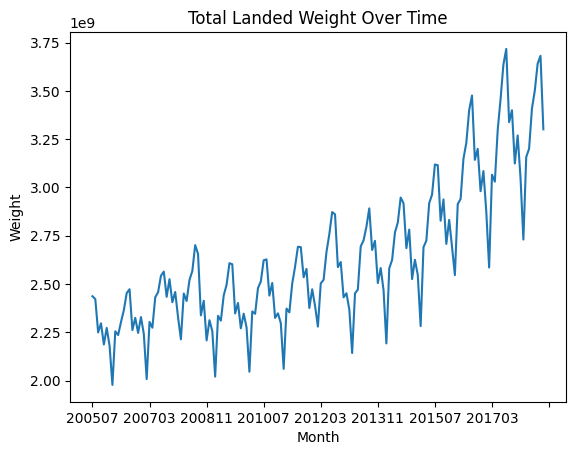

In [77]:
# Weight trend over time
df['Total Landed Weight'] = pd.to_numeric(df['Total Landed Weight'], errors='coerce')
weight_trend = df.groupby('Activity Period')['Total Landed Weight'].sum()
weight_trend.plot(kind='line', title='Total Landed Weight Over Time', xlabel='Month', ylabel='Weight')
plt.show()

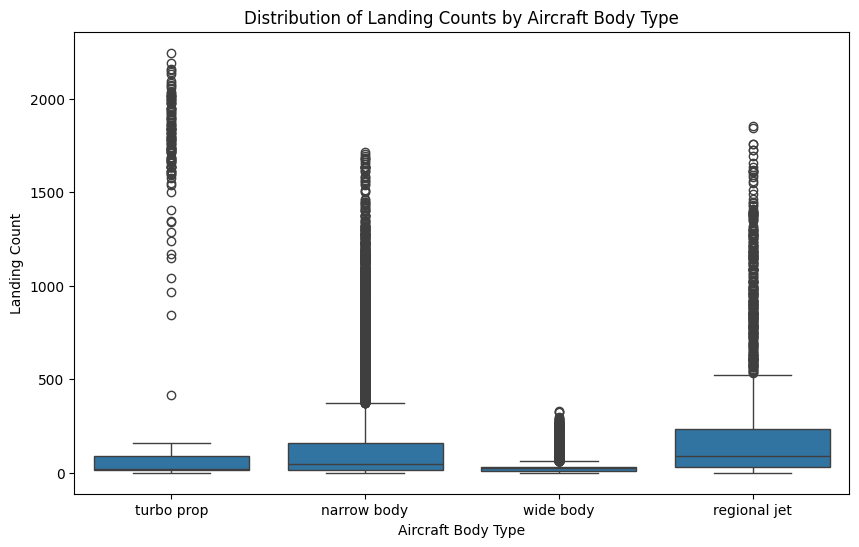

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for landing counts by aircraft body type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Aircraft Body Type', y='Landing Count')
plt.title('Distribution of Landing Counts by Aircraft Body Type')
plt.xlabel('Aircraft Body Type')
plt.ylabel('Landing Count')
plt.show()

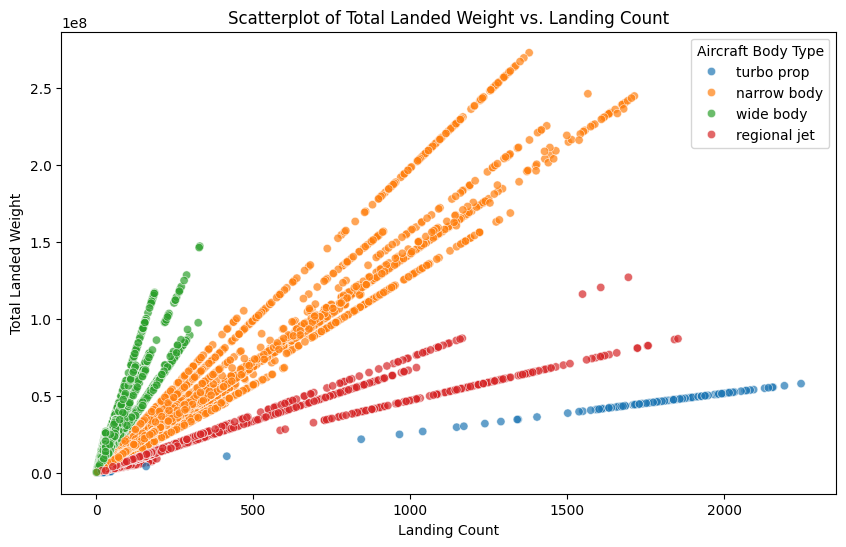

In [79]:
# Scatterplot for total landed weight vs. landing coun
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Landing Count', y='Total Landed Weight', hue='Aircraft Body Type', alpha=0.7)
plt.title('Scatterplot of Total Landed Weight vs. Landing Count')
plt.xlabel('Landing Count')
plt.ylabel('Total Landed Weight')
plt.legend(title='Aircraft Body Type')
plt.show()

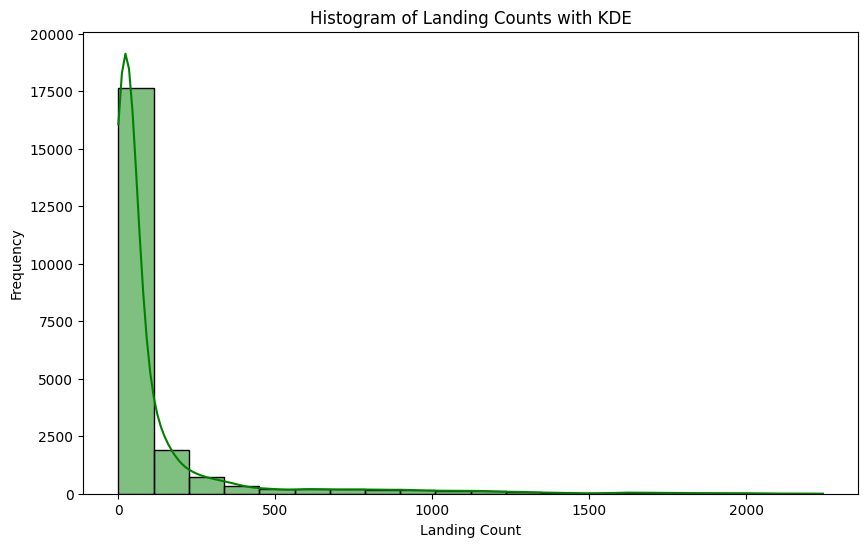

In [80]:
# Histogram with KDE
plt.figure(figsize=(10, 6))
sns.histplot(df['Landing Count'], bins=20, kde=True, color='green')
plt.title('Histogram of Landing Counts with KDE')
plt.xlabel('Landing Count')
plt.ylabel('Frequency')
plt.show()

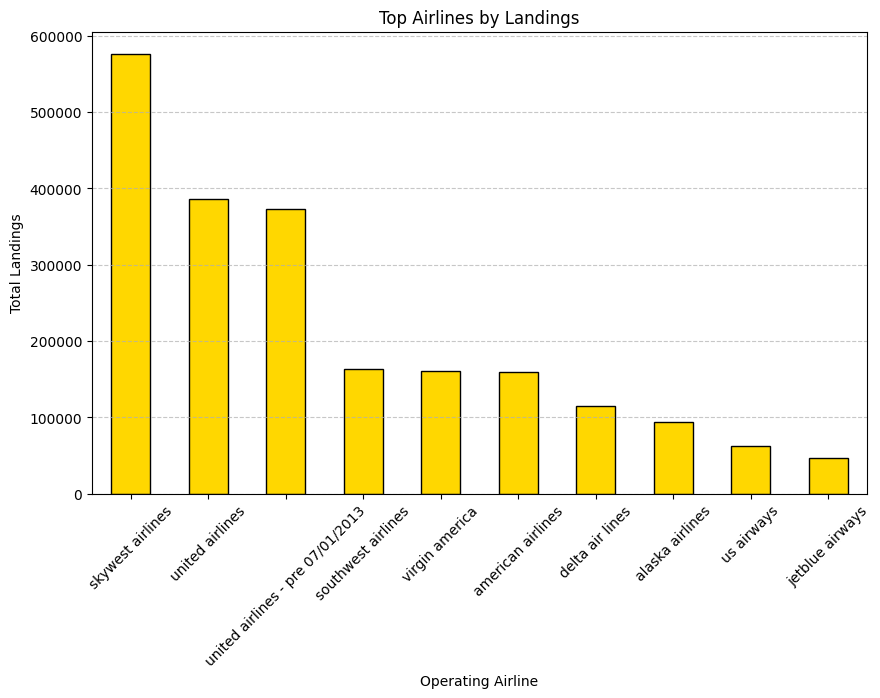

In [81]:
# Top airlines by landing count
top_airlines = df.groupby('Operating Airline')['Landing Count'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_airlines.plot(kind='bar', color='gold', edgecolor='black')
plt.title('Top Airlines by Landings')
plt.xlabel('Operating Airline')
plt.ylabel('Total Landings')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

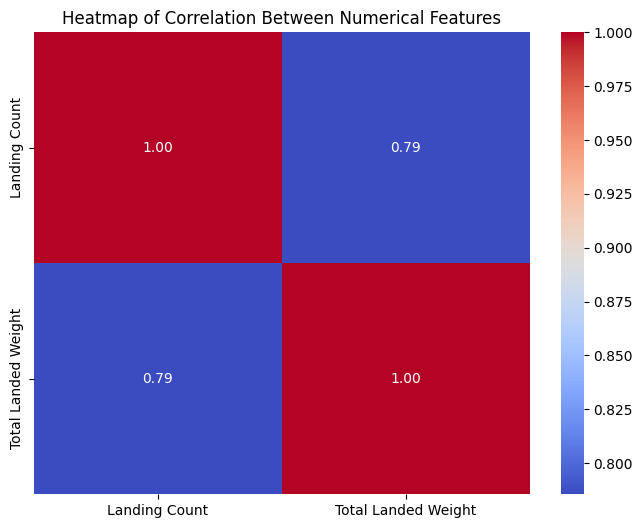

In [82]:
numerical_features = df[['Landing Count', 'Total Landed Weight']]
correlation_matrix = numerical_features.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Between Numerical Features')
plt.show()

In [83]:
df_monthly = df.groupby('date', as_index=False).agg({
    'Landing Count': 'sum',
    'Total Landed Weight': 'sum'
})
# Set index to date, ensure monthly frequency
df_monthly.set_index('date', inplace=True)
df_monthly = df_monthly.asfreq('MS')  # 'MS' = Month Start


In [84]:
# You can choose a train end date, or just use the full dataset.
train_data_lc = df_monthly['Landing Count']
train_data_tlw = df_monthly['Total Landed Weight']

In [85]:
model_lc = SARIMAX(
    train_data_lc,
    order=(1,1,1),              # (p,d,q) - placeholder, tune for your data
    seasonal_order=(1,1,1,12),  # (P,D,Q,m) with m=12 for monthly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_lc = model_lc.fit(disp=False)


In [86]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ Data Cleaning ===

# Assuming df_monthly['Landing Count'] exists
train_data_lc = df_monthly['Landing Count']

# Replace inf values and drop NaNs
train_data_lc_clean = train_data_lc.replace([np.inf, -np.inf], np.nan).dropna()

# Clip extreme outliers (3 std deviations)
upper_limit = train_data_lc_clean.mean() + 3 * train_data_lc_clean.std()
lower_limit = train_data_lc_clean.mean() - 3 * train_data_lc_clean.std()
train_data_lc_clean = train_data_lc_clean.clip(lower=lower_limit, upper=upper_limit)

# === 2️⃣ Hyperparameter Tuning Using Bayesian Optimization ===

# Define SARIMAX hyperparameter space
param_space = [
    Integer(0, 3, name='p'),
    Integer(0, 2, name='d'),
    Integer(0, 3, name='q'),
    Integer(0, 2, name='P'),
    Integer(0, 1, name='D'),
    Integer(0, 2, name='Q')
]

# Objective function to minimize AIC
@use_named_args(param_space)
def objective(**params):
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q = params['P'], params['D'], params['Q']
    
    try:
        model = SARIMAX(train_data_lc_clean,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        aic = results.aic
        
        # Handle infinite or excessively large AIC
        if np.isinf(aic) or aic > 1e10:
            return np.inf
        return aic
    except Exception as e:
        print(f"Failed for params {params}: {e}")
        return np.inf

# Run Bayesian Optimization
res = gp_minimize(objective, param_space, n_calls=30, random_state=42)

# === 3️⃣ Output Best Parameters ===

best_params = res.x
print("\n--- Optimal SARIMAX Parameters ---")
print(f"Order (p,d,q): {best_params[:3]}")
print(f"Seasonal Order (P,D,Q,12): {best_params[3:]}")
print(f"Best AIC: {res.fun}")



--- Optimal SARIMAX Parameters ---
Order (p,d,q): [np.int64(0), np.int64(2), np.int64(3)]
Seasonal Order (P,D,Q,12): [np.int64(1), np.int64(1), np.int64(2)]
Best AIC: 1691.852133350984


In [87]:

# ---- SARIMAX for Total Landed Weight ----
model_tlw = SARIMAX(
    train_data_tlw,
    order=(0,2,3),
    seasonal_order=(1,1,2,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_tlw = model_tlw.fit(disp=False)


In [88]:

future_date_str = '2025-02-01'
future_date = pd.to_datetime(future_date_str)

last_date_in_data = df_monthly.index.max()
steps = months_ahead(last_date_in_data, future_date)
if steps <= 0:
    raise ValueError("Future date is not after the dataset's last date!")

# Forecast Landing Count
forecast_lc = results_lc.get_forecast(steps=steps)
pred_lc_series = forecast_lc.predicted_mean
predicted_lc = pred_lc_series.loc[future_date]

# Forecast Total Landed Weight
forecast_tlw = results_tlw.get_forecast(steps=steps)
pred_tlw_series = forecast_tlw.predicted_mean
predicted_tlw = pred_tlw_series.loc[future_date]

print(f"\n=== Forecast for {future_date_str} ===")
print(f"Landing Count: {predicted_lc:.0f}")
print(f"Total Landed Weight: {predicted_tlw:.0f}")



=== Forecast for 2025-02-01 ===
Landing Count: 18030
Total Landed Weight: 803782452


In [89]:
df_latest_month = df[df['date'] == last_date_in_data]
if df_latest_month.empty:
    raise ValueError(f"No data found for last_date_in_data={last_date_in_data}. Adjust as needed.")

# Summation by airline
airline_sums = df_latest_month.groupby('Operating Airline')['Landing Count'].sum()
airline_proportions = airline_sums / airline_sums.sum()

# Distribute predicted_lc across airlines
airline_lc_forecast = airline_proportions * predicted_lc

# Similarly, we can distribute predicted_tlw across airlines
airline_tlw_forecast = airline_proportions * predicted_tlw

# -----------------------------
# Step B: For each airline, distribute by Aircraft Body Type
# -----------------------------
# We look at that airline's distribution of body types in the last actual month
df_latest_month_airline_body = (
    df_latest_month
    .groupby(['Operating Airline','Aircraft Body Type'])['Landing Count']
    .sum()
)

predicted_rows = []

for airline, airline_share_lc in airline_lc_forecast.items():
    # The portion of total landed weight for this airline
    airline_share_tlw = airline_tlw_forecast.get(airline, 0.0)

    # Filter to just this airline in the last month
    # to see distribution of body types
    sub = df_latest_month_airline_body.loc[airline] if airline in df_latest_month_airline_body.index.levels[0] else None

    if sub is not None and isinstance(sub, pd.Series) and not sub.empty:
        # sub is a Series with index = body types, value = landing count
        body_type_props = sub / sub.sum()  # proportion of each body type within this airline
        for btype, prop_val in body_type_props.items():
            final_lc = airline_share_lc * prop_val
            final_tlw = airline_share_tlw * prop_val

            predicted_rows.append({
                'Activity Period': future_date.strftime('%Y%m'),
                'date': future_date,
                'Operating Airline': airline,
                'Landing Count': final_lc,
                'Total Landed Weight': final_tlw
            })
    else:
        # If there's no breakdown for this airline, we can store a single row with no body type
        predicted_rows.append({
            'Activity Period': future_date.strftime('%Y%m'),
            'date': future_date,
            'Operating Airline': airline,
            'Landing Count': airline_share_lc, 
            'Total Landed Weight': airline_share_tlw
        })

# Convert to DataFrame
predicted_df = pd.DataFrame(predicted_rows)

# =========================================================
# 6) SHOW FINAL PREDICTED DATAFRAME
#    Each row = (Airline, Body Type) with forecasted LC, TLW
# =========================================================

print("\n=== Final Predicted Rows for 2025-02 (Airline x Body Type) ===")
print(predicted_df.head(20))  # Show first 20 rows



=== Final Predicted Rows for 2025-02 (Airline x Body Type) ===
   Activity Period       date                         Operating Airline  \
0           202502 2025-02-01  abc aerolineas s.a. de c.v. dba interjet   
1           202502 2025-02-01                                aer lingus   
2           202502 2025-02-01                                aeromexico   
3           202502 2025-02-01                                air canada   
4           202502 2025-02-01                                air canada   
5           202502 2025-02-01                                 air china   
6           202502 2025-02-01                                air france   
7           202502 2025-02-01                         air india limited   
8           202502 2025-02-01                           air new zealand   
9           202502 2025-02-01      air pacific limited dba fiji airways   
10          202502 2025-02-01                           alaska airlines   
11          202502 2025-02-01       

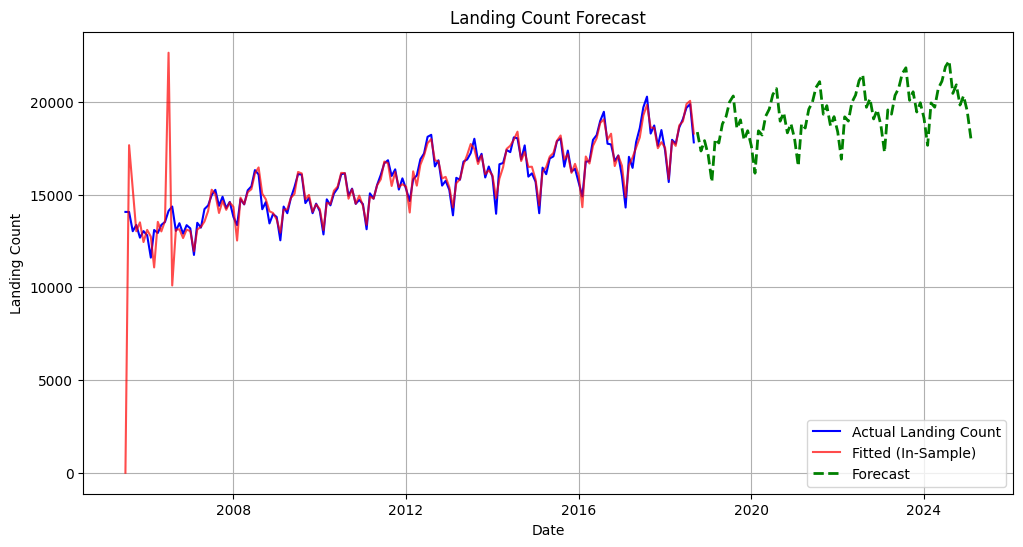

In [91]:
in_sample_pred_lc = results_lc.get_prediction(start=train_data_lc.index[0],
                                               end=train_data_lc.index[-1]).predicted_mean
actual_lc = train_data_lc

rmse_lc = np.sqrt(mean_squared_error(actual_lc, in_sample_pred_lc))
mae_lc = mean_absolute_error(actual_lc, in_sample_pred_lc)
# print(f"\n--- In-Sample Error Metrics for Landing Count ---")
# print(f"RMSE: {rmse_lc:.2f}")
# print(f"MAE: {mae_lc:.2f}")

# Create a continuous time series that combines in-sample predictions and forecast.
predicted_full_lc = pd.concat([in_sample_pred_lc, pred_lc_series])

plt.figure(figsize=(12, 6))
plt.plot(train_data_lc.index, train_data_lc, label='Actual Landing Count', color='blue')
plt.plot(in_sample_pred_lc.index, in_sample_pred_lc, label='Fitted (In-Sample)', color='red', alpha=0.7)
plt.plot(pred_lc_series.index, pred_lc_series, label='Forecast', color='green', linestyle='--', linewidth=2)
plt.title(f"Landing Count Forecast")
plt.xlabel("Date")
plt.ylabel("Landing Count")
plt.legend()
plt.grid(True)
plt.show()
